In [2]:
import os
import itertools
import xml.etree.ElementTree as ET
import cv2 
from matplotlib import pyplot as plt
import shutil
import runpy
from __future__ import print_function # Only Python 2.x
import subprocess

# Download data and models

In [3]:
%run download_facade_imgs_and_models.py


Processing facades images from https://cmp.felk.cvut.cz/~tylecr1/facade/ 
[==================================================] 34.83MB / 34.83MB
Extracting to CMP_facade_DB
Copying labels file from label_names.txt to label_names_base.txt 

[==================================================] 19.37MB / 19.37MB
Extracting to CMP_facade_DB
Copying labels file from label_names.txt to label_names_extended.txt 

Making sure labels files are identical: True 

model file models/universal_cat2vec.npy already exist

model file models/segformer_7data.pth already exist


Done


As a result of it we have folder **CMP_facade_DB** with **base** (will use for training) and **extended** (will use for testing) subfolders. 

Also, **models** folder should contain **segformer_7data.pth** and **universal_cat2vec.npy**

# Crop images

First we will play with individual axample and generalisation will be below

In [4]:
# variables
base_path = 'CMP_facade_DB'
image_extension = 'jpg'
cropped_parts_path = "%s/cropped" % base_path

(1024, 398, 3)


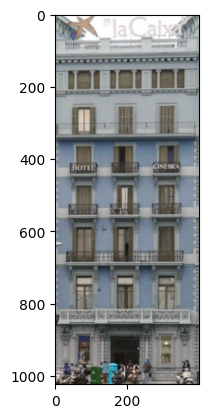

In [5]:
# we will play with this individual image
path = 'CMP_facade_DB/base/cmp_b0002.jpg'
window_name = 'image'
image = cv2.imread(path)
print(image.shape)
plt.imshow(image) 

In [6]:
# getting single xml file for this image
with open('CMP_facade_DB/base/cmp_b0002.xml') as f:
    it = itertools.chain('<root>', f, '</root>')
    root = ET.fromstringlist(it)

In [7]:
# getting all the objects, especially door
door_obj = None

for child in root:
    print(child)
    obj = {
        'label': '',
        'labelname': '',
        'flag': '',
        'points': {
            'x1': 0,
            'x2': 0,
            'y1': 0,
            'y2': 0,
        },
    }
    
    for v in child.iter("label"):
        print ("tag: %s text: %s" % (v.tag, v.text.strip())) 
        obj[v.tag] = v.text.strip()
    for v in child.iter("labelname"):
        print ("tag: %s text: %s" % (v.tag, v.text.strip()))
        obj[v.tag] = v.text.strip()
    for v in child.iter("flag"):
        print ("tag: %s text: %s" % (v.tag, v.text.strip()))
        obj[v.tag] = v.text.strip()        
    for points in child.iter("points"):
        i = 1
        for v in points.iter("x"):
            print ("tag: %s text: %s" % (v.tag.strip(), v.text.strip()))
            obj["points"]["%s%s" % (v.tag.strip(), str(i))] = float(v.text.strip())
            i += 1
        i = 1
        for v in points.iter("y"):
            print ("tag: %s text: %s" % (v.tag.strip(), v.text.strip()))
            obj["points"]["%s%s" % (v.tag.strip(), str(i))] = float(v.text.strip())
            i += 1   

    print(obj)
    
    if obj['labelname'] == "door":
        door_obj = obj    


<Element 'object' at 0x000001675774E7C0>
tag: label text: 2
tag: labelname text: facade
tag: flag text: 1
tag: x text: 0.05957
tag: x text: 0.99805
tag: y text: 0.0025126
tag: y text: 0.98995
{'label': '2', 'labelname': 'facade', 'flag': '1', 'points': {'x1': 0.05957, 'x2': 0.99805, 'y1': 0.0025126, 'y2': 0.98995}}
<Element 'object' at 0x000001675774EA90>
tag: label text: 3
tag: labelname text: window
tag: flag text: 1
tag: x text: 0.25293
tag: x text: 0.32617
tag: y text: 0.1608
tag: y text: 0.24623
{'label': '3', 'labelname': 'window', 'flag': '1', 'points': {'x1': 0.25293, 'x2': 0.32617, 'y1': 0.1608, 'y2': 0.24623}}
<Element 'object' at 0x000001675774ED60>
tag: label text: 3
tag: labelname text: window
tag: flag text: 1
tag: x text: 0.25195
tag: x text: 0.32422
tag: y text: 0.45226
tag: y text: 0.53769
{'label': '3', 'labelname': 'window', 'flag': '1', 'points': {'x1': 0.25195, 'x2': 0.32422, 'y1': 0.45226, 'y2': 0.53769}}
<Element 'object' at 0x000001675774F090>
tag: label text: 3

In [8]:
# we have a door
print(door_obj)

{'label': '4', 'labelname': 'door', 'flag': '1', 'points': {'x1': 0.87207, 'x2': 0.99512, 'y1': 0.38693, 'y2': 0.58794}}


(153, 892)
(234, 1019)


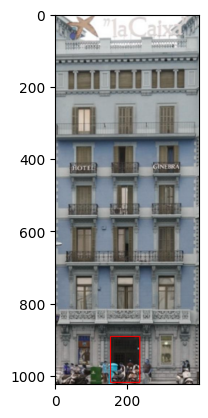

In [9]:
# drawing rectange at the door
# represents the top left corner of rectangle
start_point = (int(image.shape[1] * door_obj['points']['y1']), int(image.shape[0] * door_obj['points']['x1']))
print(start_point)
  
# represents the bottom right corner of rectangle
end_point = (int(image.shape[1] * door_obj['points']['y2']), int(image.shape[0] * door_obj['points']['x2']))
print(end_point)
  
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2
  
# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
image_with_rectangle = cv2.rectangle(image.copy(), start_point, end_point, color, thickness)
plt.imshow(image_with_rectangle) 

153 234
892 1019


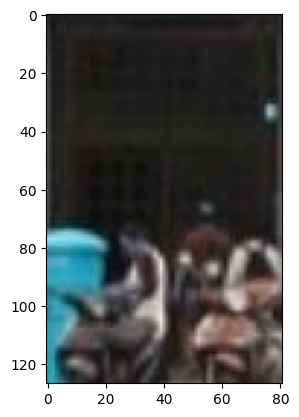

In [10]:
# cropping the door
y1 = int(image.shape[1] * door_obj['points']['y1'])
y2 = int(image.shape[1] * door_obj['points']['y2'])
print(y1, y2)
x1 = int(image.shape[0] * door_obj['points']['x1'])
x2 = int(image.shape[0] * door_obj['points']['x2'])
print(x1, x2)
crop_img = image[x1:x2, y1:y2]
plt.imshow(crop_img) 

# Cropping all the subimages

In [11]:
%run crop_facade_images.py

Cleaning CMP_facade_DB/cropped
Adding CMP_facade_DB/cropped


Processing cmp_b0001.xml
Cropped 232 items from cmp_b0001.jpg
 
Processing cmp_b0002.xml
Cropped 83 items from cmp_b0002.jpg
 
Processing cmp_b0003.xml
Cropped 139 items from cmp_b0003.jpg
 
Processing cmp_b0004.xml
Cropped 82 items from cmp_b0004.jpg
 
Processing cmp_b0005.xml
Cropped 45 items from cmp_b0005.jpg
 
Processing cmp_b0006.xml
Cropped 80 items from cmp_b0006.jpg
 
Processing cmp_b0007.xml
Cropped 98 items from cmp_b0007.jpg
 
Processing cmp_b0008.xml
Cropped 226 items from cmp_b0008.jpg
 
Processing cmp_b0009.xml
Cropped 62 items from cmp_b0009.jpg
 
Processing cmp_b0010.xml
Cropped 141 items from cmp_b0010.jpg
 
Processing cmp_b0011.xml
Cropped 99 items from cmp_b0011.jpg
 
Processing cmp_b0012.xml
Cropped 68 items from cmp_b0012.jpg
 
Processing cmp_b0013.xml
Cropped 172 items from cmp_b0013.jpg
 
Processing cmp_b0014.xml
Cropped 110 items from cmp_b0014.jpg
 
Processing cmp_b0015.xml
Cropped 143 items from cm

Cropped 54 items from cmp_b0129.jpg
 
Processing cmp_b0130.xml
Cropped 41 items from cmp_b0130.jpg
 
Processing cmp_b0131.xml
Cropped 94 items from cmp_b0131.jpg
 
Processing cmp_b0132.xml
Cropped 129 items from cmp_b0132.jpg
 
Processing cmp_b0133.xml
Cropped 85 items from cmp_b0133.jpg
 
Processing cmp_b0134.xml
Cropped 76 items from cmp_b0134.jpg
 
Processing cmp_b0135.xml
Cropped 91 items from cmp_b0135.jpg
 
Processing cmp_b0136.xml
Cropped 122 items from cmp_b0136.jpg
 
Processing cmp_b0137.xml
Cropped 74 items from cmp_b0137.jpg
 
Processing cmp_b0138.xml
Cropped 61 items from cmp_b0138.jpg
 
Processing cmp_b0139.xml
Cropped 42 items from cmp_b0139.jpg
 
Processing cmp_b0140.xml
Cropped 70 items from cmp_b0140.jpg
 
Processing cmp_b0141.xml
Cropped 141 items from cmp_b0141.jpg
 
Processing cmp_b0142.xml
Cropped 49 items from cmp_b0142.jpg
 
Processing cmp_b0143.xml
Cropped 45 items from cmp_b0143.jpg
 
Processing cmp_b0144.xml
Cropped 124 items from cmp_b0144.jpg
 
Processing cm

Cropped 115 items from cmp_b0255.jpg
 
Processing cmp_b0256.xml
Cropped 61 items from cmp_b0256.jpg
 
Processing cmp_b0257.xml
Cropped 98 items from cmp_b0257.jpg
 
Processing cmp_b0258.xml
Cropped 92 items from cmp_b0258.jpg
 
Processing cmp_b0259.xml
Cropped 176 items from cmp_b0259.jpg
 
Processing cmp_b0260.xml
Cropped 84 items from cmp_b0260.jpg
 
Processing cmp_b0261.xml
Cropped 124 items from cmp_b0261.jpg
 
Processing cmp_b0262.xml
Cropped 121 items from cmp_b0262.jpg
 
Processing cmp_b0263.xml
Cropped 100 items from cmp_b0263.jpg
 
Processing cmp_b0264.xml
Cropped 128 items from cmp_b0264.jpg
 
Processing cmp_b0265.xml
Cropped 130 items from cmp_b0265.jpg
 
Processing cmp_b0266.xml
Cropped 60 items from cmp_b0266.jpg
 
Processing cmp_b0267.xml
Cropped 70 items from cmp_b0267.jpg
 
Processing cmp_b0268.xml
Cropped 97 items from cmp_b0268.jpg
 
Processing cmp_b0269.xml
Cropped 75 items from cmp_b0269.jpg
 
Processing cmp_b0270.xml
Cropped 81 items from cmp_b0270.jpg
 
Processing

# Trainig the model our new buldings-related labels

In [12]:
test_imgs_path = 'test_imgs'
cropped_path = '%s/cropped' % base_path
labels = []
for (dirpath, dirnames, filenames) in os.walk(cropped_path):
    labels.extend(dirnames)

In [13]:
labels

['balcony',
 'blind',
 'cornice',
 'deco',
 'door',
 'facade',
 'molding',
 'pillar',
 'shop',
 'sill',
 'window']

In [14]:
labels[3:]

['deco', 'door', 'facade', 'molding', 'pillar', 'shop', 'sill', 'window']

In [ ]:
for label in labels[2:3]: 
    print('processing %s' % (label))    
    # cleaning
    print('cleaning %s' % (test_imgs_path))    
    if os.path.exists(test_imgs_path):
        shutil.rmtree(test_imgs_path)
    if not os.path.exists(test_imgs_path):        
        os.makedirs(test_imgs_path)

    # copiying cropped images to test_imgs
    cropped_imgs_path = '%s/%s' % (cropped_path, label)
    print('copy %s -> %s' % (cropped_imgs_path, test_imgs_path))
    shutil.copytree(cropped_imgs_path, test_imgs_path, dirs_exist_ok=True)
  
    # copiying cropped images to test_imgs
    print('scripting')
    os.environ["NEW_DEFINITION"] = label
    %run tools/test.py --config test_640 --new_definitions="{'': ''}"

processing cornice
cleaning test_imgs
copy CMP_facade_DB/cropped/cornice -> test_imgs


[2023-02-27 10:31:32,513 INFO test.py line 329 2708] base_size: 320
cam_id: 01
dataset_lib: dataset
distributed: False
emb_path: models/universal_cat2vec.npy
emd_method: embeddings
gpus_num: 1
ignore_label: 255
img_file_type: jpg
img_folder: image_
logit_softmax_weight: 500
model_path: models/segformer_7data.pth
multi_scale_multi_crop: False
new_definitions: {'cornice': ''}
num_model_classes: 512
num_train_classes: 194
root_dir: C:\dev\testing-tasks\mlxar\SSIW\Test_Minist/test_imgs
save_folder: ann/semantics
scales: [1.0]
single_scale_multi_crop: False
single_scale_single_crop: True
test_gpu: [0]
test_h: 320
test_w: 320
test_with_embeddings: False
user_label: None


scripting


In [1]:
del os.environ['NEW_DEFINITION']

NameError: name 'os' is not defined

# Verifiying the result

In [17]:
print('processing test')    
# cleaning
print('cleaning %s' % (test_imgs_path))   
extended_path = '%s/extended' % (base_path)
if os.path.exists(test_imgs_path):
    shutil.rmtree(test_imgs_path)
if not os.path.exists(test_imgs_path):        
    os.makedirs(test_imgs_path)

print('copy %s -> %s' % (extended_path, test_imgs_path))
for (dirpath, dirnames, filenames) in os.walk(extended_path):
    filenames = list(filter(lambda x: x.endswith(".jpg"), filenames))
    for filename in filenames:
        full_filename = '%s/%s' % (extended_path, filename)
        shutil.copy(full_filename, test_imgs_path)
        
%run tools/test.py --config test_720_ss --user_label balcony blind cornice deco door facade molding pillar shop sill window background

[2023-02-27 10:30:35,359 INFO test.py line 329 2708] base_size: 720
cam_id: 01
dataset_lib: dataset
distributed: False
emb_path: models/universal_cat2vec.npy
emd_method: embeddings
gpus_num: 1
ignore_label: 255
img_file_type: jpg
img_folder: image_
logit_softmax_weight: 500
model_path: models/segformer_7data.pth
multi_scale_multi_crop: False
new_definitions: {'blind': ''}
num_model_classes: 512
num_train_classes: 194
root_dir: C:\dev\testing-tasks\mlxar\SSIW\Test_Minist/test_imgs
save_folder: ann/semantics
scales: [1.0]
single_scale_multi_crop: False
single_scale_single_crop: True
test_gpu: [0]
test_h: 640
test_w: 640
test_with_embeddings: False
user_label: ['balcony', 'blind', 'cornice', 'deco', 'door', 'facade', 'molding', 'pillar', 'shop', 'sill', 'window', 'background']


processing test
cleaning test_imgs
copy CMP_facade_DB/extended -> test_imgs


0it [00:00, ?it/s]


label_names for img1 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


1it [00:00,  1.16it/s]


label_names for img2 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


2it [00:01,  1.19it/s]


label_names for img3 {0: 'balcony', 1: 'blind', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


3it [00:02,  1.23it/s]


label_names for img4 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


4it [00:03,  1.27it/s]


label_names for img5 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


5it [00:03,  1.28it/s]


label_names for img6 {0: 'balcony', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


6it [00:04,  1.30it/s]


label_names for img7 {0: 'balcony', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


7it [00:05,  1.30it/s]


label_names for img8 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


8it [00:06,  1.29it/s]


label_names for img9 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


9it [00:07,  1.24it/s]


label_names for img10 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 6: 'molding', 7: 'pillar', 10: 'window', 255: 'unlabel'}


11it [00:08,  1.26it/s]


label_names for img11 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


12it [00:09,  1.21it/s]


label_names for img12 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}

label_names for img13 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 6: 'molding', 255: 'unlabel'}


13it [00:10,  1.26it/s]


label_names for img14 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


14it [00:11,  1.28it/s]


label_names for img15 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


15it [00:11,  1.29it/s]


label_names for img16 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 9: 'sill', 10: 'window', 11: 'background', 255: 'unlabel'}


16it [00:12,  1.27it/s]


label_names for img17 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


17it [00:13,  1.23it/s]


label_names for img18 {0: 'balcony', 1: 'blind', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


18it [00:14,  1.18it/s]


label_names for img19 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


19it [00:15,  1.17it/s]


label_names for img20 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


20it [00:16,  1.13it/s]


label_names for img21 {0: 'balcony', 5: 'facade', 10: 'window', 255: 'unlabel'}


21it [00:17,  1.15it/s]


label_names for img22 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


22it [00:18,  1.10it/s]


label_names for img23 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


23it [00:19,  1.11it/s]


label_names for img24 {0: 'balcony', 5: 'facade', 6: 'molding', 10: 'window', 255: 'unlabel'}


24it [00:19,  1.15it/s]


label_names for img25 {0: 'balcony', 5: 'facade', 10: 'window', 255: 'unlabel'}


25it [00:20,  1.15it/s]


label_names for img26 {0: 'balcony', 4: 'door', 5: 'facade', 6: 'molding', 10: 'window', 255: 'unlabel'}


26it [00:21,  1.16it/s]


label_names for img27 {0: 'balcony', 5: 'facade', 10: 'window', 255: 'unlabel'}


27it [00:22,  1.20it/s]


label_names for img28 {0: 'balcony', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


28it [00:24,  1.22s/it]


label_names for img29 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


29it [00:25,  1.05s/it]


label_names for img30 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


31it [00:26,  1.18it/s]


label_names for img31 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


32it [00:27,  1.19it/s]


label_names for img32 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}

label_names for img33 {0: 'balcony', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


34it [00:28,  1.28it/s]


label_names for img34 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


35it [00:29,  1.33it/s]


label_names for img35 {0: 'balcony', 5: 'facade', 10: 'window', 255: 'unlabel'}

label_names for img36 {0: 'balcony', 1: 'blind', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}


37it [00:30,  1.38it/s]


label_names for img37 {0: 'balcony', 4: 'door', 5: 'facade', 7: 'pillar', 10: 'window', 255: 'unlabel'}

label_names for img38 {0: 'balcony', 4: 'door', 5: 'facade', 10: 'window', 255: 'unlabel'}


38it [00:31,  1.41it/s]


label_names for img39 {0: 'balcony', 5: 'facade', 10: 'window', 255: 'unlabel'}


39it [00:32,  1.20it/s]


KeyboardInterrupt: 